In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Starter
* Data -> Build Dataset -> split dataset
* vocab
* init_MLP_params
* training
* loss
* sampling

In [12]:
words = open("names.txt").read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [13]:
vocab = sorted(set(''.join(words)))

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos) # Used for initiate emb lookup table

In [14]:
block_size = 3
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context), ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
train_idx = int(0.8 * len(words))
val_idx   = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:train_idx])
x_val  , y_val   = build_dataset(words[train_idx:val_idx])
x_test , y_test  = build_dataset(words[val_idx:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
emb_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dim)              , generator=g)
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) * 0.2
b1 = torch.randn(hidden_dim                        , generator=g) * 0.01
W2 = torch.randn((hidden_dim, vocab_size)          , generator=g) * 0.01
b2 = torch.randn(vocab_size                        , generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(f"Parameter number: {sum([p.nelement() for p in parameters])}")
for p in parameters:
    p.requires_grad = True

Parameter number: 11897


For the loss at first step, it was `27.8817` which is very large. It means that the model is very confidently wrong. Ideally, we expect the uniform probs distribution at initialization.

In [37]:
logits = torch.tensor([-0.5, 0.1, 2, 0])
probs = logits.exp() / logits.exp().sum(dim=0, keepdim=True)
loss = -probs[2].log().mean()
loss

tensor(0.3126)

In [53]:
max_steps  = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Forward
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = x_train[idx], y_train[idx] 
    
    emb = C[Xb]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000  else 0.01
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad
            
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


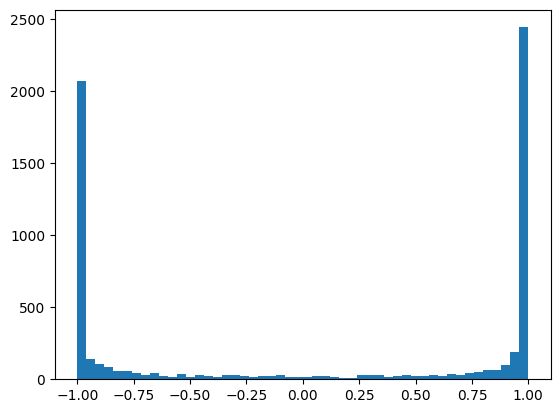

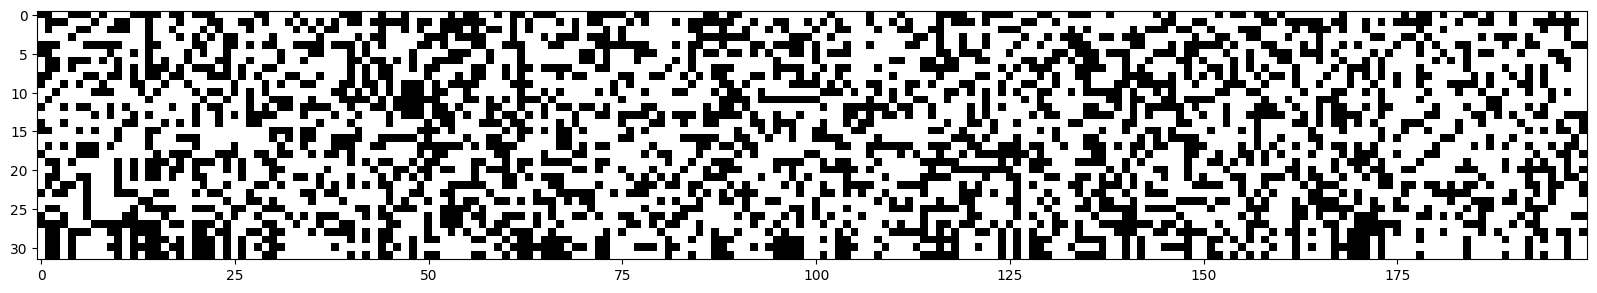

In [47]:
# Activation of hidden state
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap="gray")

(array([  4.,   1.,   3.,   0.,   4.,   7.,   7.,  14.,  13.,  21.,  33.,
         60.,  62.,  86., 148., 140., 231., 236., 276., 260., 297., 357.,
        470., 571., 451., 356., 339., 286., 308., 307., 196., 219., 142.,
        137.,  74.,  84.,  66.,  46.,  24.,  18.,  14.,  15.,   4.,   3.,
          3.,   3.,   1.,   0.,   1.,   2.]),
 array([-22.79827309, -21.84011379, -20.8819545 , -19.9237952 ,
        -18.96563591, -18.00747662, -17.04931732, -16.09115803,
        -15.13299873, -14.17483944, -13.21668015, -12.25852085,
        -11.30036156, -10.34220226,  -9.38404297,  -8.42588367,
         -7.46772438,  -6.50956509,  -5.55140579,  -4.5932465 ,
         -3.6350872 ,  -2.67692791,  -1.71876862,  -0.76060932,
          0.19754997,   1.15570927,   2.11386856,   3.07202785,
          4.03018715,   4.98834644,   5.94650574,   6.90466503,
          7.86282433,   8.82098362,   9.77914291,  10.73730221,
         11.6954615 ,  12.6536208 ,  13.61178009,  14.56993938,
         15.528098

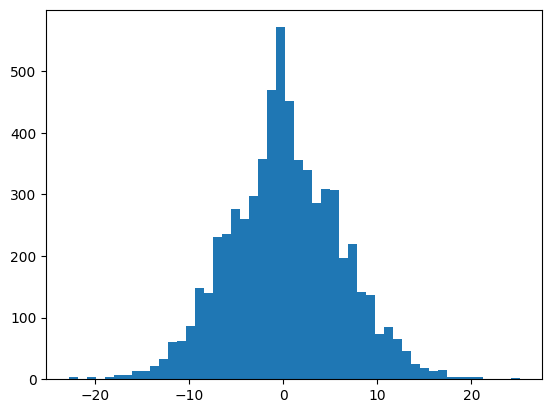

In [29]:
# The range before hidden layer is saturated.
plt.hist(hpreact.view(-1).tolist(), 50)

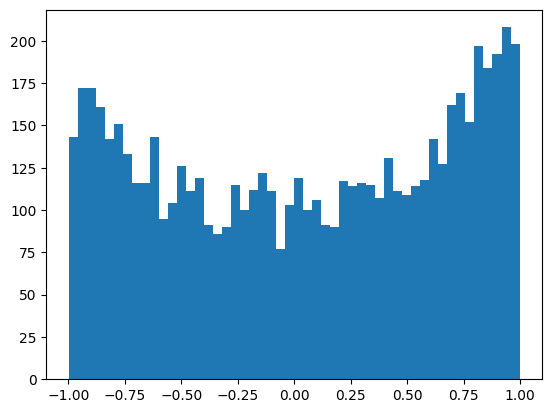

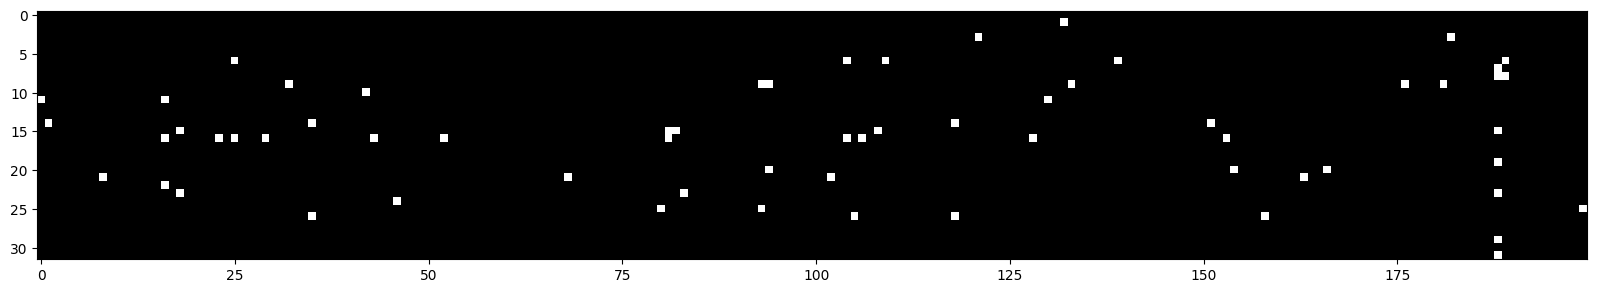

In [50]:
# Activation of hidden state after refinement
h_line = h.view(-1).tolist()
plt.hist(h_line, 50)
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap="gray")

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367116, -3.62009738, -3.47652361, -3.33294983, -3.18937606,
        -3.04580228, -2.90222851, -2.75865473, -2.61508096, -2.47150718,
        -2.32793341, -2.18435963, -2.04078586, -1.89721208, -1.75363831,
        -1.61006453, -1.46649076, -1.32291698, -1.1793432 , -1.03576943,
        -0.89219565, -0.74862188, -0.6050481 , -0.46147433, -0.31790055,
        -0.17432678, -0.030753  ,  0.11282077,  0.25639455,  0.39996832,
         0.5435421 ,  0.68711587,  0.83068965,  0.97426342,  1.1178372 ,
         1.26141098,  1.40498475,  1.54855853,  1.6921323 ,  1.83570608,
         1.97927985,  2.12285363,  2.2664274 ,  2.41000118,  2.55357495,
 

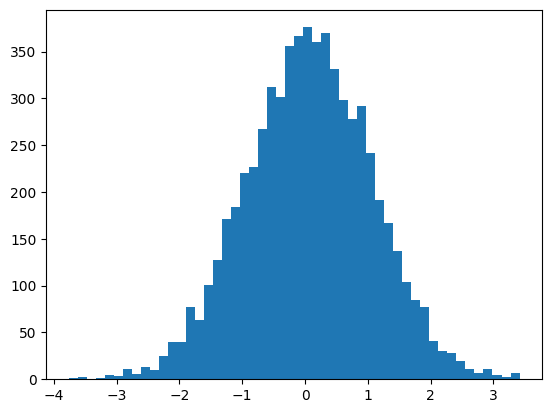

In [51]:
# The range before hidden layer is saturated.
plt.hist(hpreact.view(-1).tolist(), 50)

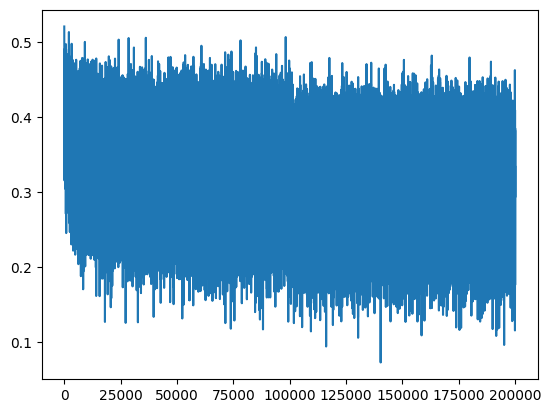

In [54]:
plt.plot(torch.arange(len(lossi)), lossi)

In [55]:
def split_loss(mode="train"):
    x, y = {
        "train": (x_train, y_train),
        "val"  : (x_val  , y_val),
        "test" : (x_test , y_test)
    }[mode]
    x = x_train if mode == "train" else x_val
    y = y_train if mode == "train" else y_val
    
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{mode} loss over the entire dataset is: {loss.item()}")
    
split_loss("train")
split_loss("val")

train loss over the entire dataset is: 2.0355966091156006
val loss over the entire dataset is: 2.102677822113037


1. `loss` for initial setting: train 2.1256, val 2.1698
2. `loss` for revising logits uniform init: train 2.0695, val 2.1311
3. `loss` for revising logits uniform init + fix saturated tanh: train 2.0355, val 2.1026

In [56]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sampling
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join([itos[i] for i in out]))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.
